# ITI105 Machine Learning Project

Team members:
* Lye Suh Jeng (7487427Y)
* Lee Li Neng (6203055B)
* Lim Chan Boon (9704541M)
---
Project Problem: 4 (a) as in suggested project:
* The success of the song can often been measured by whether the song is on the Hit Chart such as Billboard Hot 100. It is important for music labels to know what makes a song successful so that they can focus their budget on making songs that has the highest chance of being successful.
---
We want to solve the problem statement by using the follow steps:
1.   Load dataset
2.   Discover & visualize data to gain insights
3.   Prepare data
4.   Feature scaling
6.   Feature reduction
5.   Split data into train and test datasets
6.   Train, fine tune and evaluate models
7.   Compare performance of models
8.   Deploy the model

# (1) Gather and Load dataset

In [213]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

df = pd.read_csv('https://raw.githubusercontent.com/dy018/project105/main/song_data.csv')

## 2.1 Split features into numeric and categorical features

In [214]:
# song_popularity is target. The rest of columns are features
# Get list of features from df
features = df.columns[1:].tolist()

# put features into 2 types: categorical features and numeric features
category_features = ['audio_mode', 'time_signature', 'key']
numeric_features = [feature for feature in features if feature not in category_features]
print(">>> Categorical features are:", category_features)
print(">>> Numeric features are:", numeric_features)


>>> Categorical features are: ['audio_mode', 'time_signature', 'key']
>>> Numeric features are: ['song_popularity', 'song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']


# (3) Prepare data


In [215]:
# Backup original df
df2 = df.copy()

## (3)(a) Prepare data by removing any duplicat records if any


In [216]:
# Remove duplicate rows (if any)
print(">>>> Original df's shape:", df.shape)

counter = 0
row,col = df.shape

df2.drop_duplicates(inplace=True)

if df2.shape==(row,col):
    print('>>> The dataset doesn\'t have any duplicates')
else:
    print('>>> Number of duplicates dropped/fixed:', {row-df2.shape[0]})
    print(">>> New df2's shape after removing dupliate rows", df2.shape)

>>>> Original df's shape: (18835, 15)
>>> Number of duplicates dropped/fixed: {3909}
>>> New df2's shape after removing dupliate rows (14926, 15)


## (3)(b) Drop categorical features & 'song_name'

In [217]:
# backup df:
df3 = df2.copy()

# drop category_features in df
df3.drop(category_features, axis=1, inplace=True)
df3.drop('song_name', axis=1, inplace=True)
print(">>> New df3's shape after removing categorical features:", df3.shape)
df3.head()

>>> New df3's shape after removing categorical features: (14926, 11)


,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,0.0294,167.060,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,0.0498,105.256,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0.2550,-7.828,0.0792,123.881,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,0.1070,122.444,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,0.0313,172.011,0.574


In [218]:
df4 = df3.copy()

## (3)(c) Handle imbalanced datasets

In [219]:
Q1_df = df4[df4['song_popularity'] <= 25]
Q2_df = df4[(df2['song_popularity'] > 25) & (df2['song_popularity'] <= 50)]
Q3_df = df4[(df2['song_popularity'] > 51) & (df2['song_popularity'] <= 75)]
Q4_df = df4[(df2['song_popularity'] > 75) & (df2['song_popularity'] <= 100)]

Q1_length = len(Q1_df)
Q2_length = len(Q2_df)
Q3_length = len(Q3_df)
Q4_length = len(Q4_df)
print(">>> Number of records in Q1:", Q1_length)
print(">>> Number of records in Q2:", Q2_length)
print(">>> Number of records in Q3:", Q3_length)
print(">>> Number of records in Q4:", Q4_length)

>>> Number of records in Q1: 2195
>>> Number of records in Q2: 4870
>>> Number of records in Q3: 6556
>>> Number of records in Q4: 981


In [220]:
# determine which df has highest number of data
df_lengths = {
    'Q1_df': Q1_df,
    'Q2_df': Q2_df,
    'Q3_df': Q3_df,
    'Q4_df': Q4_df
}

max_df_name = max(df_lengths, key=lambda k: len(df_lengths[k]))
max_df = df_lengths[max_df_name]
print(f">>> The DataFrame with the maximum number of records is: {max_df_name} with {len(max_df)} records")


>>> The DataFrame with the maximum number of records is: Q3_df with 6556 records


In [221]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# Upsample 3 df to be the same length with max_df
def upsample_df(tmp_df, max_length):
  df_upsampled = resample(tmp_df,
                          replace=True,     # sample with replacement
                          n_samples=max_length,    # to match majority class
                          random_state=40)  # reproducible results
  return df_upsampled

Q1_df_upsampled = upsample_df(Q1_df, len(max_df))
Q2_df_upsampled = upsample_df(Q2_df, len(max_df))
Q4_df_upsampled = upsample_df(Q4_df, len(max_df))

In [222]:
print(">>> Number of records in Q1_df_upsampled:", len(Q1_df_upsampled))
print(">>> Number of records in Q2_df_upsampled:", len(Q2_df_upsampled))
print(">>> Number of records in Q3_df_upsampled:", len(Q4_df_upsampled))


>>> Number of records in Q1_df_upsampled: 6556
>>> Number of records in Q2_df_upsampled: 6556
>>> Number of records in Q3_df_upsampled: 6556


In [223]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([Q1_df_upsampled, Q2_df_upsampled, Q3_df, Q4_df_upsampled])

In [224]:
df_upsampled.shape

(26224, 11)

In [225]:
df_upsampled.head(10)

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence
17571,0,259040,0.04830,0.673,0.671,0.000000,0.3360,-5.156,0.2280,155.695,0.828
11214,0,206626,0.03760,0.738,0.724,0.080400,0.2510,-6.467,0.0441,119.986,0.807
15217,0,209531,0.47500,0.539,0.936,0.104000,0.1060,-3.803,0.1120,128.015,0.225
6061,3,225760,0.50000,0.530,0.943,0.232000,0.9320,-6.025,0.0489,144.749,0.778
18074,15,132653,0.00693,0.597,0.606,0.764000,0.0944,-12.254,0.0400,95.024,0.464
4113,20,173384,0.14100,0.851,0.482,0.000002,0.0844,-6.136,0.0429,123.947,0.297
18264,0,229306,0.55700,0.445,0.342,0.000026,0.1180,-9.686,0.1460,93.721,0.298
14105,2,200813,0.00739,0.550,0.941,0.000000,0.0651,-2.467,0.1420,136.993,0.469
11287,21,161174,0.83300,0.411,0.176,0.879000,0.1330,-22.848,0.0559,170.450,0.956
10210,11,330826,0.34100,0.604,0.668,0.000574,0.0376,-5.716,0.0430,142.433,0.867


# 5) Feature scaling

In [226]:
# define target
Y = df_upsampled['song_popularity']

# define features
X = df_upsampled.drop(['song_popularity'], axis=1)

In [227]:
# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
min_max_scaled_data = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(min_max_scaled_data, columns=X.columns)

print (">>> Display first 5 records of training data after scaling:\n")
X_scaled.head()

>>> Display first 5 records of training data after scaling:



,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence
0,0.138216,0.048493,0.681864,0.671320,0.000000,0.330725,0.824059,0.242295,0.642523,0.841463
1,0.108891,0.037750,0.747720,0.724430,0.080642,0.243204,0.789842,0.046865,0.495159,0.820122
2,0.110516,0.476907,0.546099,0.936869,0.104313,0.093904,0.859373,0.119022,0.528293,0.228659
3,0.119596,0.502008,0.536981,0.943884,0.232698,0.944399,0.801378,0.051966,0.597351,0.790650
4,0.067504,0.006957,0.604863,0.606185,0.766299,0.081960,0.638800,0.042508,0.392146,0.471545


In [254]:
import pickle
import joblib

# Save scaler to .pkl files
scaler_filename = "scaler.pkl"
joblib.dump(min_max_scaler , scaler_filename)

['scaler.pkl']

In [229]:
print (">>> Display df's statistic after scaling:\n")
X_scaled.describe()

>>> Display df's statistic after scaling:



,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence
count,26224.000000,26224.000000,26224.000000,26224.000000,26224.000000,26224.000000,26224.000000,26224.000000,26224.000000,26224.000000
mean,0.116487,0.255788,0.639724,0.646285,0.077722,0.170832,0.766401,0.107853,0.500350,0.534604
std,0.036177,0.288439,0.159401,0.212347,0.220869,0.148969,0.097846,0.110969,0.119160,0.245341
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.097329,0.023091,0.537994,0.505977,0.000000,0.080210,0.725525,0.040064,0.404737,0.341463
50%,0.112155,0.130521,0.652482,0.675328,0.000009,0.110379,0.789033,0.059617,0.495333,0.531504
75%,0.130176,0.411646,0.755826,0.815618,0.002497,0.217463,0.831132,0.125399,0.577676,0.731707
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [230]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, train_size=0.8, test_size=0.2, random_state=40)
X_train.reset_index(drop=True,inplace=True)

print(">>> Size of trainig set: ", X_train.shape)
print(">>> Size of testing set: ", X_test.shape)

>>> Size of trainig set:  (20979, 10)
>>> Size of testing set:  (5245, 10)


In [189]:
X_train.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence
0,0.157074,0.088754,0.695035,0.675328,0.114343,0.078563,0.675941,0.057386,0.604718,0.612805
1,0.154170,0.366465,0.653495,0.524015,0.021966,0.093904,0.648249,0.046652,0.461901,0.814024
2,0.101589,0.485943,0.838906,0.369695,0.000000,0.107290,0.764420,0.276302,0.618873,0.557927
3,0.111541,0.079517,0.706180,0.505977,0.000000,0.076709,0.831706,0.034538,0.412689,0.524390
4,0.103309,0.306224,0.778116,0.611195,0.000000,0.612850,0.809652,0.328374,0.388622,0.414634


In [231]:
from sklearn.linear_model import Lasso

# Step 1: Use Lasso Regression for Feature Selection
lasso = Lasso()
#lasso = Lasso(alpha = 0.05)

# Define the hyperparameter grid
#param_grid = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]}
param_grid = {'alpha': [0.005, 0.01, 0.05, 0.1]}

# Perform GridSearchCV to find the best alpha
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best Lasso model
best_lasso = grid_search.best_estimator_

# Get the indices of the selected features
selected_features = np.where(best_lasso.coef_ != 0)[0]
print(f"Selected features: {selected_features}")


Selected features: [0 1 2 3 4 5 6 7 8 9]


In [237]:
len(selected_features)

10

In [238]:
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'alpha': 0.005}


In [239]:
X_train = X_train.iloc[:, selected_features]
X_test = X_test.iloc[:, selected_features]

In [240]:
X_train.columns

Index(['song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'audio_valence'],
      dtype='object')

In [241]:
X_train.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence
0,0.157074,0.088754,0.695035,0.675328,0.114343,0.078563,0.675941,0.057386,0.604718,0.612805
1,0.154170,0.366465,0.653495,0.524015,0.021966,0.093904,0.648249,0.046652,0.461901,0.814024
2,0.101589,0.485943,0.838906,0.369695,0.000000,0.107290,0.764420,0.276302,0.618873,0.557927
3,0.111541,0.079517,0.706180,0.505977,0.000000,0.076709,0.831706,0.034538,0.412689,0.524390
4,0.103309,0.306224,0.778116,0.611195,0.000000,0.612850,0.809652,0.328374,0.388622,0.414634


In [161]:
X_train.columns

Index(['song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'audio_valence'],
      dtype='object')

# 6.  Train, fine tune, and evaluate model's performance

## Model Evaluation Functions

In [242]:
# calculates r2_score
def cal_r2(y_true, y_pred):
  r2 = r2_score(y_true, y_pred)
  return r2

# Calculates adjusted_r2
def cal_adj_r2(x_df, r2):
  number_variables = x_df[1] - 1
  adjusted_r2 = 1 - ((1-r2) * (x_df[0]-1)) / (x_df[0] - number_variables -1)
  return adjusted_r2

def cal_mse(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  return mse

def cal_performance(x_train_shape, x_test_shape, y_train, y_train_pred, y_test, y_test_pred):
  r2_train = cal_r2(y_train, y_train_pred)
  r2_test = cal_r2(y_test, y_test_pred)
  adj_r2_train = cal_adj_r2(x_train_shape, r2_train)
  adj_r2_test = cal_adj_r2(x_test_shape, r2_test)
  mse_train = cal_mse(y_train, y_train_pred)
  mse_test = cal_mse(y_test, y_test_pred)

  performance_dict = {
    'r2_train': r2_train,
    'r2_test': r2_test,
    'adj_r2_train': adj_r2_train,
    'adj_r2_test': adj_r2_test,
    'mse_train': mse_train,
    'mse_test': mse_test
    }
  return performance_dict

In [243]:
from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest Regressor
rf = RandomForestRegressor(random_state=40)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Make predictions
rf_pred_train = best_rf.predict(X_train)
rf_pred_test = best_rf.predict(X_test)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [244]:
# Evaluate the model
rf_performance = cal_performance(X_train.shape, X_test.shape, y_train, rf_pred_train, y_test, rf_pred_test)
print(rf_performance)

{'r2_train': 0.9561410591062361, 'r2_test': 0.8131555206842723, 'adj_r2_train': 0.9561222346287673, 'adj_r2_test': 0.8128342980837295, 'mse_train': 31.011760329257736, 'mse_test': 133.50508508650992}


In [165]:
# convert dictionary to dataframe
rf_df = pd.DataFrame.from_dict(rf_performance, orient='index', columns=['RF'])

print(">>> Model performance:\n")
rf_df

>>> Model performance:



,RF
r2_train,0.956141
r2_test,0.813156
adj_r2_train,0.956122
adj_r2_test,0.812834
mse_train,31.011760
mse_test,133.505085


# Validation



In [166]:
print(y_test[0:10].values)
print(rf_pred_test[:10])

[80 41 78  9 57 22 89 15 44 41]
[78.93920833 32.45842352 76.77332684 16.46043001 60.78914196 22.512875
 89.87765203 15.15542136 43.8138566  42.48424315]


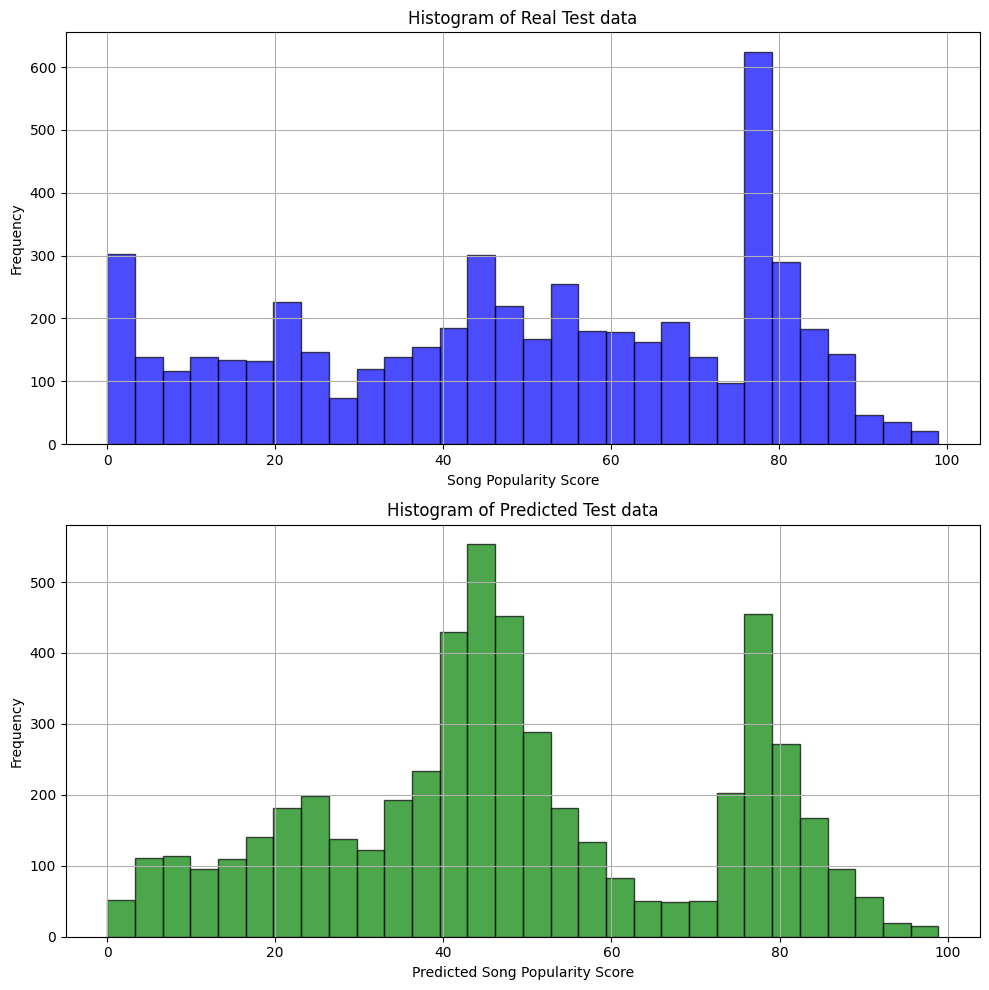

In [167]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the first histogram on the first subplot
ax1.hist(y_test, bins=30, color='blue', alpha=0.7, edgecolor='black')
ax1.set_title('Histogram of Real Test data')
ax1.set_xlabel('Song Popularity Score')
ax1.set_ylabel('Frequency')
ax1.grid(True)

# Plot the second histogram on the second subplot
ax2.hist(rf_pred_test, bins=30, color='green', alpha=0.7, edgecolor='black')
ax2.set_title('Histogram of Predicted Test data')
ax2.set_xlabel('Predicted Song Popularity Score')
ax2.set_ylabel('Frequency')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# 7. Deployment

## 7.1 Convert the Model to a Pickle File

In [248]:
import pickle

# Save the trained model to a pickle file
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)


## 7.2 Set Up Gradio for Deployment

In [170]:
#Gradio provides a simple interface to create a web application for your model
!pip install gradio


In [249]:
def predict_song_popularity(song_duration_ms, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, audio_valence):
    # Your prediction code here
    pass




In [245]:
input1 = X_test.iloc[0]
input1

,25076
song_duration_ms,0.098164
acousticness,0.417670
danceability,0.833840
energy,0.418797
instrumentalness,0.000000
liveness,0.092875
loudness,0.688286
speechiness,0.175345
tempo,0.495044
audio_valence,0.281504


In [246]:
y_test.iloc[0]

80

In [255]:
import gradio as gr
import pickle

# Load the pre-trained model (assuming you have already trained and saved it as 'song_popularity_model.pkl')
with open('best_rf_model.pkl', 'rb') as f:
    best_rf = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

scaler

array(['song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'audio_valence'], dtype=object)

In [258]:
print(scaler)

['song_duration_ms' 'acousticness' 'danceability' 'energy'
 'instrumentalness' 'liveness' 'loudness' 'speechiness' 'tempo'
 'audio_valence']


In [257]:
test = [262333, 0.00552, 0.496, 0.682,0.0000294,0.0589, -4.095, 0.0294, 167.06, 0.474]
scaled_input = scaler.transform([test])
predicted_score = best_rf.predict(scaled_input)
print(predicted_score)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [135]:
import gradio as gr
import pickle

# Load the pre-trained model (assuming you have already trained and saved it as 'song_popularity_model.pkl')
with open('best_rf_model.pkl', 'rb') as f:
    best_rf = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

def predict_song_popularity(song_duration_ms, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, audio_valence):
    # Make the prediction using the model
    input_data = [[song_duration_ms, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, audio_valence]]
    scaled_input = scaler.transform(input_data)
    predicted_score = best_rf.predict(scaled_input)

    # Define the interpretation of the score
    if predicted_score >= 75:
        interpretation = "This song is predicted to be very popular!"
    elif predicted_score >= 50:
        interpretation = "This song is predicted to have moderate popularity."
    else:
        interpretation = "This song is predicted to have low popularity."

    # Additional explanation
    explanation = "Scores closer to 100 indicate higher popularity, while scores closer to 0 suggest lower popularity. This prediction is based on features like acousticness, instrumentalness, and more."

    return predicted_score, interpretation, explanation

def create_interface():
    # Define the inputs
    inputs = [
        gr.Slider(minimum=0, maximum=1000000, label="Song Duration (ms)"),
        gr.Slider(minimum=0, maximum=1, label="Acousticness"),
        gr.Slider(minimum=0, maximum=1, label="Danceability"),
        gr.Slider(minimum=0, maximum=1, label="Energy"),
        gr.Slider(minimum=0, maximum=1, label="Instrumentalness"),
        gr.Slider(minimum=0, maximum=1, label="Liveness"),
        gr.Slider(minimum=-40, maximum=2, label="Loudness"),
        gr.Slider(minimum=0, maximum=1, label="Speechiness"),
        gr.Slider(minimum=0, maximum=300, label="Tempo (BPM)"),  # Adjusted max value for tempo
        gr.Slider(minimum=0, maximum=1, label="audio_valence"),
    ]

    # Define the outputs
    outputs = [
        gr.Textbox(label="Predicted Popularity Score"),
        gr.Textbox(label="Interpretation"),
        gr.Textbox(label="Explanation")
    ]

    # Create the Gradio interface with 5 repeated images
    interface = gr.Interface(
        fn=predict_song_popularity,
        inputs=inputs,
        outputs=outputs,
        title="Project 105 - Song Popularity Predictor",
        description="Predicts the popularity of a song based on various features.",
        theme="default",
        article="""
        <div style="display: flex; justify-content: space-between;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
        </div>
        <br><br>
        Use this tool to predict how popular a song might be based on its characteristics. The popularity score ranges from 0 to 100, with higher scores indicating greater potential popularity. Consider features like acousticness, instrumentalness, and more to understand what makes a song resonate with listeners.
        """
    )

    return interface

# Launch the interface
interface = create_interface()
interface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://ebcb60e86c946f4b69.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 288, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1931, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1516, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

480000 0.61 0.55 0.59 0.38 151 -27 0.81 0.4 0.07


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 288, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1931, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1516, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e565e2b0cb478320b3.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://4828e30c89bfb68407.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://b00e151b3d22757444.gradio.live
Killing tunnel 127.0.0.1:7863 <> https://468c303809c2dea4db.gradio.live
Killing tunnel 127.0.0.1:7864 <> https://1a2250adc82a2c883f.gradio.live
Killing tunnel 127.0.0.1:7865 <> https://f230d9f35adb0cc4b1.gradio.live
Killing tunnel 127.0.0.1:7866 <> https://e80592acb687e83ee3.gradio.live
Killing tunnel 127.0.0.1:7867 <> https://0c5e63db417cbfefd4.gradio.live
Killing tunnel 127.0.0.1:7868 <> https://d56c32c4e3359d9643.gradio.live
Killing tunnel 127.0.0.1:7869 <> https://ebcb60e86c946f4b69.gradio.live
